In [1]:
from nilearn import image
import nilearn
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets
from nilearn import plotting
import argparse
import sys 
from os import path

%matplotlib inline

In [2]:
BIDS_dir = '/oak/stanford/groups/russpold/data/uh2/aim1/BIDS_scans'

fmriprep_dir = '/oak/stanford/groups/russpold/data/uh2/aim1/BIDS_scans/derivatives/fmriprep'
secondlvl_dir = '/oak/stanford/groups/russpold/data/uh2/aim1/BIDS_scans/derivatives/2ndlevel/'

task_dirs = [i for i in glob(path.join(secondlvl_dir, '*')) if '.' not in i]

In [3]:
label_dict = {1.0: ['central visual', 'central visual', 'central visual', 'central visual'],
 2.0: ['peripheral visual',
  'peripheral visual',
  'peripheral visual',
  'peripheral visual',
  'peripheral visual',
  'peripheral visual'],
 3.0: ['somatomotor A', 'somatomotor A'],
 4.0: ['somatomotor B',
  'somatomotor B',
  'somatomotor B',
  'somatomotor B',
  'somatomotor B',
  'somatomotor B',
  'somatomotor B',
  'somatomotor B'],
 5.0: ['dorsal attention A',
  'dorsal attention A',
  'dorsal attention A',
  'dorsal attention A',
  'dorsal attention A',
  'dorsal attention A'],
 6.0: ['dorsal attention B',
  'dorsal attention B',
  'dorsal attention B',
  'dorsal attention B',
  'dorsal attention B',
  'dorsal attention B',
  'dorsal attention B',
  'dorsal attention B'],
 7.0: ['salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A',
  'salience / ventral attention A'],
 8.0: ['salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B',
  'salience / ventral attention B'],
 9.0: ['limbic A', 'limbic A'],
 10.0: ['limbic B', 'limbic B'],
 12.0: ['control A',
  'control A',
  'control A',
  'control A',
  'control A',
  'control A',
  'control A',
  'control A',
  'control A',
  'control A',
  'control A'],
 13.0: ['control B',
  'control B',
  'control B',
  'control B',
  'control B',
  'control B',
  'control B',
  'control B',
  'control B',
  'control B',
  'control B'],
 11.0: ['control C', 'control C', 'control C', 'control C'],
 16.0: ['default A',
  'default A',
  'default A',
  'default A',
  'default A',
  'default A',
  'default A',
  'default A',
  'default A'],
 17.0: ['default B',
  'default B',
  'default B',
  'default B',
  'default B',
  'default B',
  'default B'],
 15.0: ['default C',
  'default C',
  'default C',
  'default C',
  'default C',
  'default C'],
 14.0: ['temporal parietal', 'temporal parietal']}

# __ get task z_score per network (yeo et al 2011, 17network)__

In [ ]:
yeo = datasets.fetch_atlas_yeo_2011()

masker = NiftiLabelsMasker(labels_img=yeo['thick_17'], standardize=False,
                           memory='nilearn_cache')

parcel_z_scores = {
    'True': {},
    'False': {},
}
for task_dir in task_dirs:
    curr_task = task_dir.split('/')[-1]
    rt_dirs = glob(path.join(task_dir, '*'))
    for rt_dir in rt_dirs:
        rt_flag = rt_dir.split('RT-')[-1].split('_')[0]
        try:
            parcs = masker.fit_transform([path.join(rt_dir, 'contrast-task.nii.gz')])
        except ValueError:
            parcs = masker.fit_transform([path.join(rt_dir, 'contrast-trial.nii.gz')]) #for WATT3
        parcel_z_scores[rt_flag][curr_task] = parcs[0]

In [ ]:
RT_False_Zs = pd.DataFrame(parcel_z_scores['False'])
labels = [label_dict[i+1][0] for i in RT_False_Zs.index]
RT_False_Zs.index=labels
RT_False_Zs.index.name= 'Yeo (2011) label'

In [ ]:
RT_False_Zs

In [ ]:
RT_False_Zs.to_csv('uh2Aim1_yeoNetworks_Zscores_RT-False.csv')

In [ ]:
RT_True_Zs = pd.DataFrame(parcel_z_scores['True'])
labels = [label_dict[i+1][0] for i in RT_True_Zs.index]
RT_True_Zs.index=labels
RT_True_Zs.index.name= 'Yeo (2011) label'

In [ ]:
RT_True_Zs

In [ ]:
RT_True_Zs.to_csv('uh2Aim1_yeoNetworks_Zscores_RT-True.csv')

# __Getting task-locked BOLD timeseries__

In [6]:
from bids import BIDSLayout
import pandas as pd
from nilearn import input_data
import nibabel as nb
from nilearn._utils import check_niimg
from nilearn import image
import numpy as np


In [7]:
sourcedata_layout = BIDSLayout(BIDS_dir)

In [26]:
def _make_psc(data):
    mean_img = image.mean_img(data)

    # Replace 0s for numerical reasons
    mean_data = mean_img.get_data()
    mean_data[mean_data == 0] = 1
    denom = image.new_img_like(mean_img, mean_data)

    return image.math_img('data / denom[..., np.newaxis] * 100 - 100',
                          data=data, denom=denom)

def extract_timecourse_from_nii(atlas,
                                nii,
                                mask=None,
                                confounds=None,
                                atlas_type=None,
                                t_r=None,
                                low_pass=None,
                                high_pass=1./128,
                                *args,
                                **kwargs):
    """
    Extract time courses from a 4D `nii`, one for each label 
    or map in `atlas`,
    This method extracts a set of time series from a 4D nifti file
    (usually BOLD fMRI), corresponding to the ROIs in `atlas`.
    It also performs some minimal preprocessing using 
    `nilearn.signal.clean`.
    It is especially convenient when using atlases from the
    `nilearn.datasets`-module.
    Parameters
    ----------
    atlas: str  
        Path to 3D atlas image to be passed into NiftiLabelsMasker
    nii: 4D niimg-like object
        This NiftiImage contains the time series that need to
        be extracted using `atlas`
    mask: 3D niimg-like object
        Before time series are extracted, this mask is applied,
        can be useful if you want to exclude non-gray matter.
    confounds: CSV file or array-like, optional
        This parameter is passed to nilearn.signal.clean. Please 
        see the related documentation for details.
        shape: (number of scans, number of confounds)
    t_r, float, optional
        Repetition time of `nii`. Can be important for
        temporal filtering.
    low_pass: None or float, optional
        This parameter is passed to signal.clean. Please see the related
        documentation for details
    high_pass: None or float, optional
        This parameter is passed to signal.clean. Please see the related
        documentation for details
    Examples
    --------
    >>> from nilearn import datasets
    >>> data = '/data/ds001/derivatives/fmriprep/sub-01/func/sub-01_task-checkerboard_bold.nii.gz'
    >>> atlas = datasets.fetch_atlas_pauli_2017()
    >>> ts = extract_timecourse_from_nii(atlas,
                                         data,
                                         t_r=1.5)
    >>> ts.head()
    """

    standardize = kwargs.pop('standardize', False)
    detrend = kwargs.pop('detrend', False)



    masker = input_data.NiftiLabelsMasker(atlas,
                                          mask_img=mask,
                                          standardize=standardize,
                                          detrend=detrend,
                                          t_r=t_r,
                                          low_pass=low_pass,
                                          high_pass=high_pass,
                                          *args, **kwargs)


    data = _make_psc(nii)

    results = masker.fit_transform(data,
                                   confounds=confounds)

    if t_r is None:
        t_r = 1

    index = pd.Index(np.arange(0,
                               t_r*data.shape[-1],
                               t_r),
                     name='time')
    try:
        out_df =  pd.DataFrame(results,
                            index=index)
    except ValueError:
        out_df =  pd.DataFrame(results,
                            index=index[:-1])        
    return(out_df)

def get_onsets(events, task_conditions=['Task'], scanner_times=None):
    onsets = events.loc[events.conditions.isin(task_conditions), 'onsets'].values
    #round to nearest scanner time if available
    if scanner_times is not None: 
#         onsets = [min(scanner_times, key=lambda x:abs(x-i)) for i in onsets] #takes closest value
        onsets = [scanner_times[scanner_times > i].min() for i in onsets] #takes closest _larger_ value
        
    return(onsets)

In [24]:
yeo = datasets.fetch_atlas_yeo_2011()

deriv_base_path = '/oak/stanford/groups/russpold/data/uh2/aim1/BIDS_scans/derivatives/fmriprep/sub-*/ses-*/func/'
source_path = path.join(BIDS_dir, 'sub-*/ses-*/func/*%s*bold.nii.gz') #for oringal filepaths for metadata
prep_path = path.join(deriv_base_path, '*%s*space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz') #for mnispace preprocessed
evs_path = path.join(BIDS_dir, 'derivatives/1stlevel/s*/%s/simplified_events_RT-False_beta-False.csv') #for timelocking
dsgn_path = path.join(BIDS_dir, 'derivatives/1stlevel/s*/%s/design_RT-False_beta-False.csv') #for confounds

task_sources = glob(source_path % 'CCTHot')
task_funcs = glob(prep_path % 'CCTHot')
task_evs = glob(evs_path % 'CCTHot')
task_dsgns = glob(dsgn_path % 'CCTHot')


task_funcs.sort()
task_dsgns.sort()
task_sources.sort()
task_evs.sort()

print('num raw funcs', len(task_sources))
print('num mni funcs', len(task_funcs))
print('num ev files', len(task_evs))
print('num dsgn files', len(task_dsgns))

num raw funcs 106
num mni funcs 104
num ev files 104
num dsgn files 102


In [29]:
confounds_to_include = ['framewise_displacement', 'a_comp_cor_00',
                        'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
                        'a_comp_cor_04', 'a_comp_cor_05', 'a_comp_cor_06',
                        'a_comp_cor_07', 'trans_x', 'trans_y', 'trans_z',
                        'rot_x', 'rot_y', 'rot_z']

num_nets = 17
num_trs = 15 #to average over


subject_network_responses = np.empty((num_trs, num_nets, len(task_funcs)))
subject_network_responses[:] = np.nan
for idx, func in enumerate([task_funcs[6]]): #failed for s251
    
    #set up nan array 
    meaned_responses = np.empty((num_trs,num_nets))
    meaned_responses[:] = np.nan
    
    #make sure sub has all required files
    sub_str = func.split('sub-')[1].split('/')[0]
    print(sub_str)
    #get relavent sub strs
    sub_dsgn = [i for i in task_dsgns if sub_str in i]
    sub_source = [i for i in task_sources if sub_str in i]
    sub_evs = [i for i in task_evs if sub_str in i]
    
    #if they are missing a file, skip them
    if (len(sub_dsgn)==0) | (len(sub_source)==0) | (len(sub_evs)==0):
        print('missing something for sub'+sub_str)
        subject_network_responses[:,:,idx] = meaned_responses
        continue
    sub_dsgn = sub_dsgn[0]
    sub_source = sub_source[0]
    sub_evs = sub_evs[0]
    
    meta = sourcedata_layout.get_metadata(sub_source)
    confounds= pd.read_csv(sub_dsgn) 
    evs = pd.read_csv(sub_evs)

    TR = meta['RepetitionTime']



    #extract timeseries for 
    tc = extract_timecourse_from_nii(yeo['thick_17'],
                                     func, #testing on the first funcional run
                                     t_r=TR,
                                     atlas_type='labels',
                                     low_pass=None,
                                     high_pass=1./128,
                                     confounds=confounds[confounds_to_include].values)

    # get task onsets, shift to the nearest (larger) TR
    onsets = get_onsets(evs, task_conditions=['AX', 'AY', 'BX', 'BY'], scanner_times=tc.index)

    # take num_trs of signal for each network at each task onset
    timelocked_data = np.zeros((num_trs, num_nets, len(onsets)))
    for jdx, onset in enumerate(onsets):
        curr_resp = tc.loc[onset:onset+(num_trs*TR), :].head(num_trs).values
        timelocked_data[:,:, jdx] = curr_resp
        
    # mean across onsets
    meaned_responses = np.mean(timelocked_data, axis=2)
    
    #append subj means to get group
    subject_network_responses[:,:,idx] = meaned_responses

s251


AttributeError: 'DataFrame' object has no attribute 'conditions'

In [18]:
t_r=.68
index = pd.Index(np.arange(0,
                   t_r*779,
                   t_r),
        name='time')

In [ ]:
dsgn_path = path.join(BIDS_dir, 'derivatives/1stlevel/s*/%s/design_RT-False_beta-False.csv') #for confounds

task_evs = glob(evs_path % 'DPX')
task_dsgns = glob(dsgn_path % 'DPX')


In [ ]:
'simplified_events_RT-False_beta-False.csv'

In [ ]:
task_evs = glob(evs_path % 'DPX')
evs = pd.read_csv(task_evs[0])
evs.conditions.unique()

In [ ]:
task_full_resps = np.load('tst_DPX_task_17network_responses_full.npy')
N = np.count_nonzero(~np.isnan(dpx_full_resps[0,0,:]))

mean_resps = np.nanmean(task_full_resps, axis=2)
std_resps = np.nanstd(task_full_resps, axis=2)
lower = mean_resps - (1.96*std_resps)/np.sqrt(N)
upper = mean_resps + (1.96*std_resps)/np.sqrt(N)

fig, axs = plt.subplots(17,1,figsize=(8,80))
for n_i in range(mean_resps.shape[1]):
    color = (network_colors.loc[n_i+1, 'R']/255,
             network_colors.loc[n_i+1, 'G']/255,
             network_colors.loc[n_i+1, 'B']/255)
    axs[n_i].plot(mean_resps[:,n_i], color=color)
    axs[n_i].fill_between(np.arange(0,20), lower[:,n_i], upper[:,n_i], alpha=0.25, color=color)
    axs[n_i].set_xticks(np.arange(0,21,2)) 
    axs[n_i].set_ylabel(label_dict[n_i+1][0])


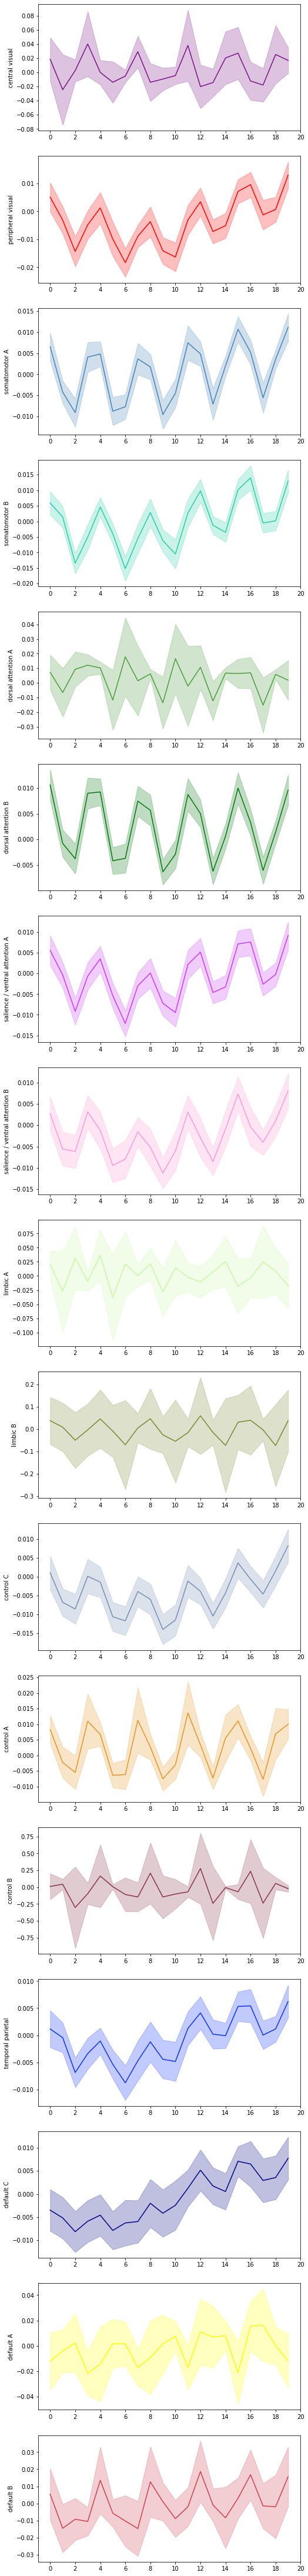

In [33]:
task_full_resps = np.load('ANT_task_17network_responses_full.npy')
N = np.count_nonzero(~np.isnan(task_full_resps[0,0,:]))

mean_resps = np.nanmean(task_full_resps, axis=2)
std_resps = np.nanstd(task_full_resps, axis=2)
lower = mean_resps - (1.96*std_resps)/np.sqrt(N)
upper = mean_resps + (1.96*std_resps)/np.sqrt(N)

fig, axs = plt.subplots(17,1,figsize=(8,80))
for n_i in range(mean_resps.shape[1]):
    color = (network_colors.loc[n_i+1, 'R']/255,
             network_colors.loc[n_i+1, 'G']/255,
             network_colors.loc[n_i+1, 'B']/255)
    axs[n_i].plot(mean_resps[:,n_i], color=color)
    axs[n_i].fill_between(np.arange(0,20), lower[:,n_i], upper[:,n_i], alpha=0.25, color=color)
    axs[n_i].set_xticks(np.arange(0,21,2)) 
    axs[n_i].set_ylabel(label_dict[n_i+1][0])

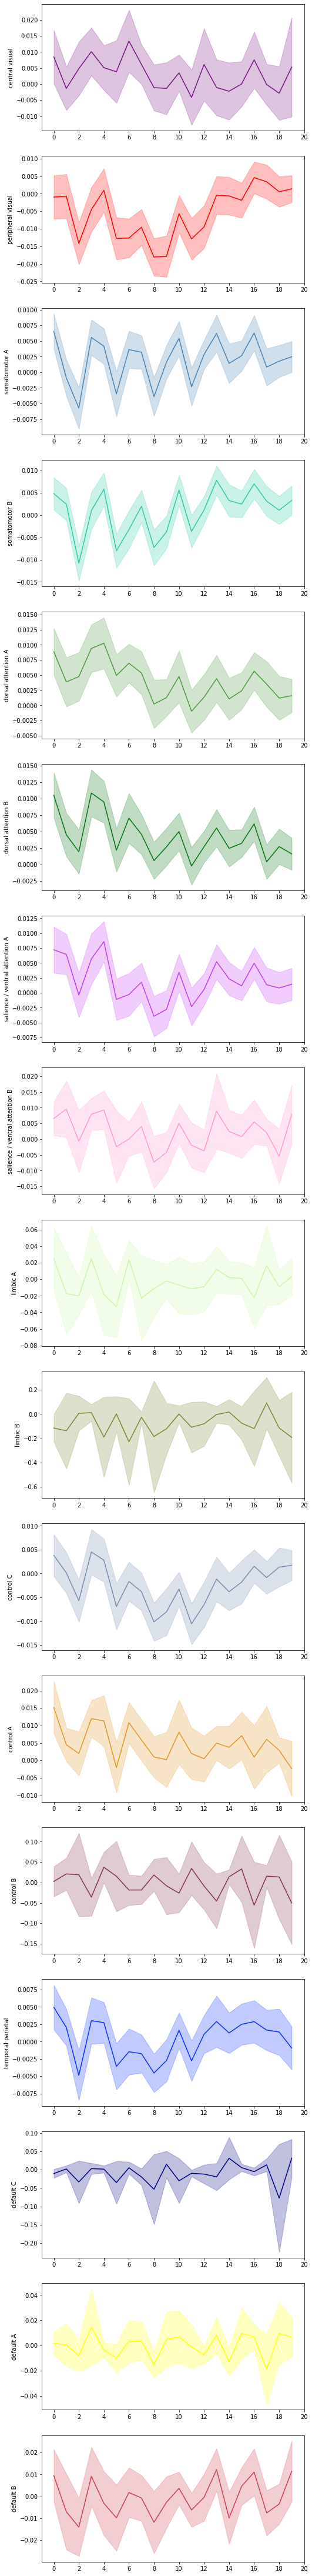

In [34]:
task_full_resps = np.load('stroop_task_17network_responses_full.npy')
N = np.count_nonzero(~np.isnan(task_full_resps[0,0,:]))

mean_resps = np.nanmean(task_full_resps, axis=2)
std_resps = np.nanstd(task_full_resps, axis=2)
lower = mean_resps - (1.96*std_resps)/np.sqrt(N)
upper = mean_resps + (1.96*std_resps)/np.sqrt(N)

fig, axs = plt.subplots(17,1,figsize=(8,80))
for n_i in range(mean_resps.shape[1]):
    color = (network_colors.loc[n_i+1, 'R']/255,
             network_colors.loc[n_i+1, 'G']/255,
             network_colors.loc[n_i+1, 'B']/255)
    axs[n_i].plot(mean_resps[:,n_i], color=color)
    axs[n_i].fill_between(np.arange(0,20), lower[:,n_i], upper[:,n_i], alpha=0.25, color=color)
    axs[n_i].set_xticks(np.arange(0,21,2)) 
    axs[n_i].set_ylabel(label_dict[n_i+1][0])

In [14]:
task_files = glob('*_task_17network_responses_full.npy')
task_files

['motorSelectiveStop_task_17network_responses_full.npy',
 'tst_DPX_task_17network_responses_full.npy',
 'twoByTwo_task_17network_responses_full.npy',
 'DPX_task_17network_responses_full.npy',
 'stopSignal_task_17network_responses_full.npy',
 'discountFix_task_17network_responses_full.npy',
 'CCTHot_task_17network_responses_full.npy',
 'stroop_task_17network_responses_full.npy',
 'ANT_task_17network_responses_full.npy']

In [6]:
network_colors = pd.read_excel('yeo_17network_colors.xlsx')

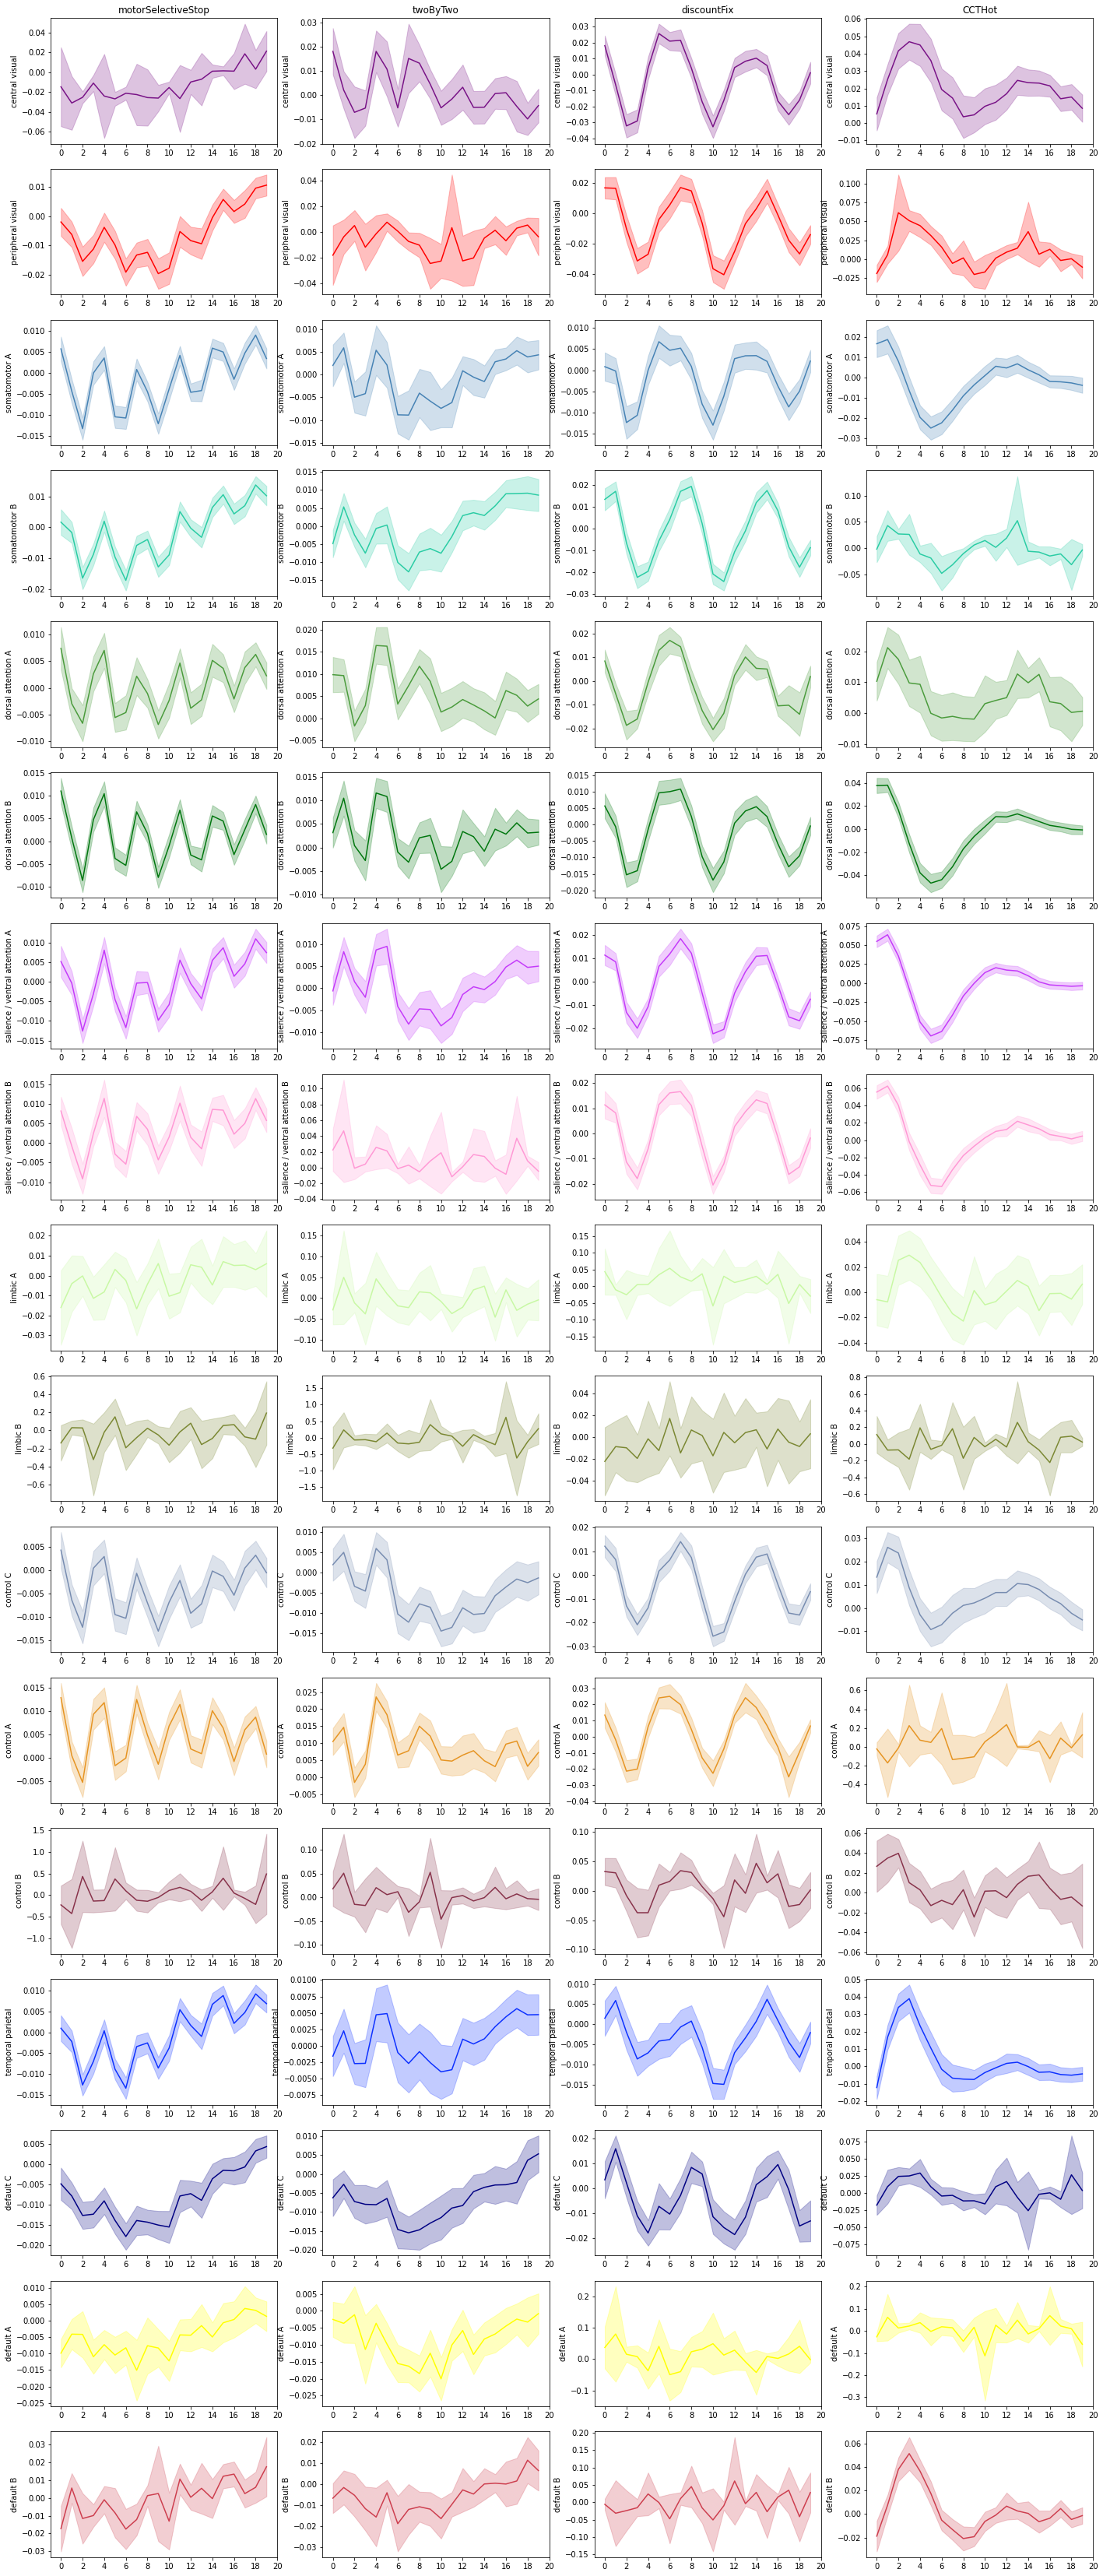

In [15]:
# task_files = glob('*_task_17network_responses_full.npy')
# task_files.sort()

task_files = ['motorSelectiveStop_task_17network_responses_full.npy',
 'twoByTwo_task_17network_responses_full.npy',
 'discountFix_task_17network_responses_full.npy',
 'CCTHot_task_17network_responses_full.npy']

fig, axs = plt.subplots(17, len(task_files), figsize=(6*len(task_files),60))

task_titles=[]
for t_i, task_file in enumerate(task_files):
    task_name = task_file.replace('_task_17network_responses_full.npy', '')
    task_titles.append(task_name)
    
    task_full_resps = np.load(task_file)

    N = np.count_nonzero(~np.isnan(task_full_resps[0,0,:]))

    mean_resps = np.nanmean(task_full_resps, axis=2)
    std_resps = np.nanstd(task_full_resps, axis=2)
    lower = mean_resps - (1.96*std_resps)/np.sqrt(N)
    upper = mean_resps + (1.96*std_resps)/np.sqrt(N)

    for n_i in range(mean_resps.shape[1]):
        color = (network_colors.loc[n_i+1, 'R']/255,
                 network_colors.loc[n_i+1, 'G']/255,
                 network_colors.loc[n_i+1, 'B']/255)
        axs[n_i, t_i].plot(mean_resps[:,n_i], color=color)
        axs[n_i, t_i].fill_between(np.arange(0,20), lower[:,n_i], upper[:,n_i], alpha=0.25, color=color)
        axs[n_i, t_i].set_xticks(np.arange(0,21,2)) 
        axs[n_i, t_i].set_ylabel(label_dict[n_i+1][0])
        
for ax, col in zip(axs[0], task_titles):
    ax.set_title(col)
    
plt.savefig('aim1_task_timelockedBOLD_17networks.png', bbox_inches='tight', dpi=400)